<a href="https://colab.research.google.com/github/alheliou/Fairness/blob/main/Attributions_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
  <img src="https://github.com/deel-ai/xplique/blob/master/docs/assets/banner.png?raw=true"/>
</p>

---

- 📘 <a href="https://deel-ai.github.io/xplique"> Documentation </a>
- <img src="https://github.githubassets.com/images/icons/emoji/octocat.png" width=20> <a href="https://github.com/deel-ai/xplique"> Github </a>
- 🦊 <a href="https://github.com/deel-ai/xplique/blob/master/TUTORIALS.md"> More Xplique tutorials </a>

---
# 👋 Welcome to the **Regression and Tabular Data** for Attribution method tutorial

The objective of this notebook is to apply the Xplique library to a regression problem with tabular data. Here we will use the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) Dataset and use the Tensorflow [tutorial](https://www.tensorflow.org/tutorials/keras/regression) to build a DNN model for it.

In [ ]:
!pip install -q xplique

     |████████████████████████████████| 123 kB 7.0 MB/s 


## Build the Use Case
We will follow the Tensorflow Tutorial from here

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

### Get the data

In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [ ]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

In [ ]:
# the dataset contains na value, we just drop them
dataset = dataset.dropna()
# the origin column is not numeric so we convert it to a one hot-hot
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Split the data into train and test

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Split features from labels

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

### Normalize data
The features have different range of value, so it is a good practice to normalize them. So before doing anything we will use sklearn StandardScaler on our data

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features.values)
test_features = scaler.transform(test_features.values)


### DNN Regression
It is now time to implements single-input and multiple-inputs DNN models

In [ ]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

Now if we use the previous normalization layer we will build a DNN model for the full dataset

In [ ]:
dnn_model = build_and_compile_model()

In [ ]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 7.01 s, sys: 593 ms, total: 7.61 s
Wall time: 21.9 s


### Visualize model's training

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

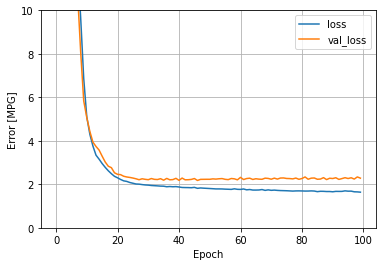

In [ ]:
plot_loss(history)

### Make predictions


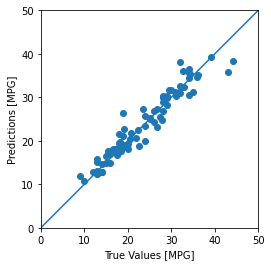

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

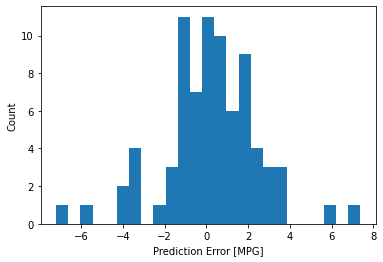

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

## Explain a Regression model (with Xplique)

We now have at our disposal a model trained for a regression task and we would like to use the Xplique library in order to have some highlights towards it. First, let's load this model and import the xplique library.

In [ ]:
from xplique.attributions import (Saliency,
                             IntegratedGradients,
                             KernelShap,
                             Lime,
                             Occlusion,
                             SmoothGrad,
                             VarGrad,
                             SquareGrad,
                             GuidedBackprop,
                             DeconvNet,
                             GradientInput
)

In [ ]:
inputs_tf, targets_tf = tf.cast(test_features, tf.float32), tf.cast(test_labels, tf.float32)
targets_tf = tf.expand_dims(targets_tf, axis=-1)
new_targets_tf = tf.ones((78,1))

In [ ]:
methods_params = [
    ("Saliency", Saliency, {}),
    ("Integrated Gradients", IntegratedGradients, {}),
    ("KernelShap", KernelShap, {}),
    ("Lime", Lime, {}),
    ("Occlusion", Occlusion, {"patch_size": 1, "patch_stride": 1}),
    ("SmoothGrad", SmoothGrad, {}),
    ("VarGrad", VarGrad, {}),
    ("SquareGrad", SquareGrad, {}),
    ("GuidedBackprop", GuidedBackprop, {}),
    ("DeconvNet", DeconvNet, {}),
    ("GradientInput", GradientInput, {})
]

In [ ]:
# get the different explanations
explanations = []

for name, Cls, params in methods_params:

    explainer   = Cls(dnn_model, **params)
    explanation = explainer(inputs_tf, new_targets_tf)

    explanations.append((name, explanation))

Now we will have a look at our results

In [ ]:
features_name= [
    'Cylinders',
    'Displacement',
    'Horsepower',
    'Weight',
    'Acceleration',
    'Model Year',
    'Europe',
    'Japan',
    'USA'
]

In [ ]:
from xplique.plots import plot_feature_impact, plot_mean_feature_impact, summary_plot_tabular

### On a single sample

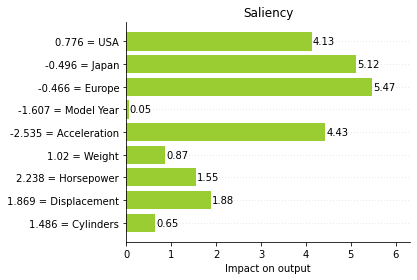

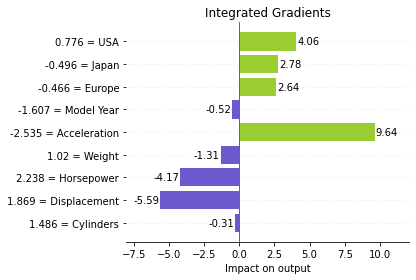

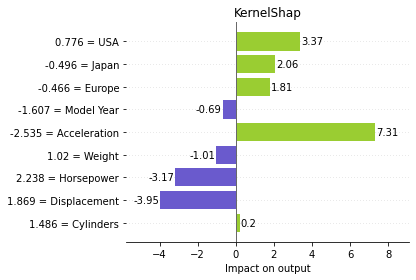

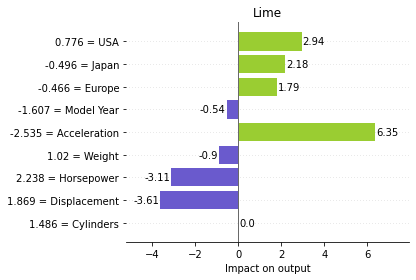

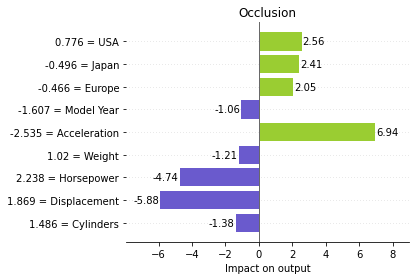

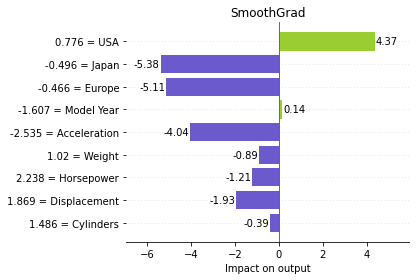

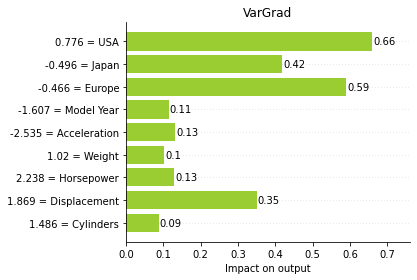

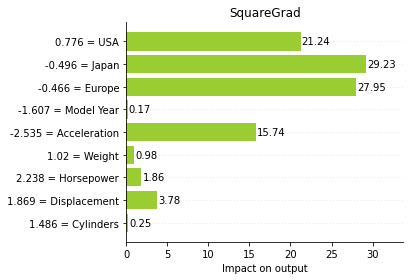

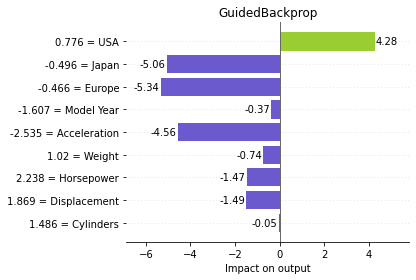

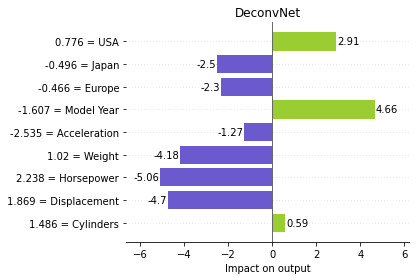

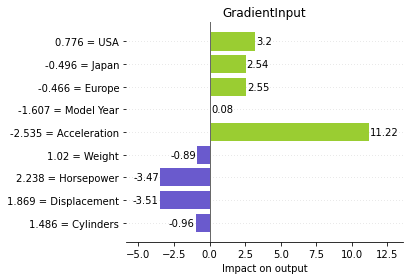

In [ ]:
for exp_index, (exp_method, exp) in enumerate(explanations):
    plot_feature_impact(exp[0], features_name, test_features[0])
    plt.title(exp_method)
    plt.show()

### The mean impact for every sample

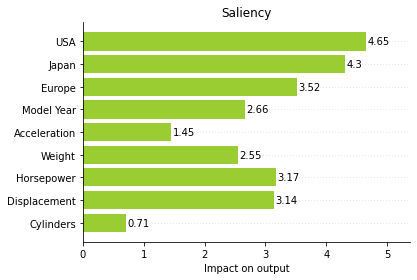

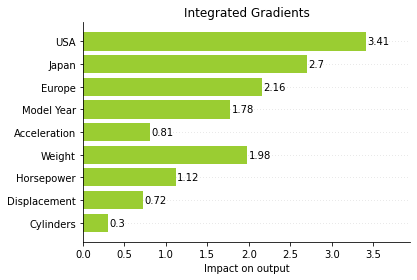

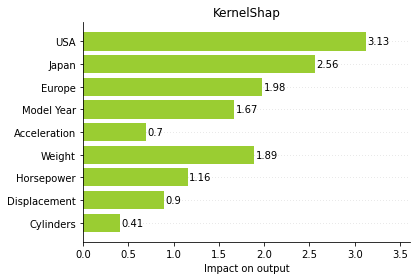

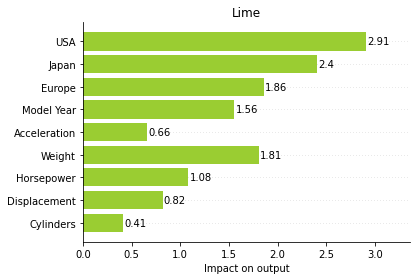

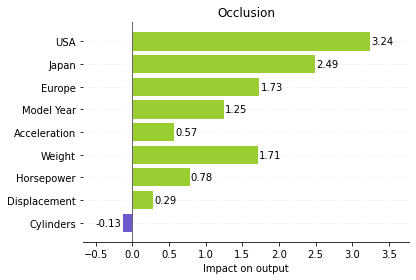

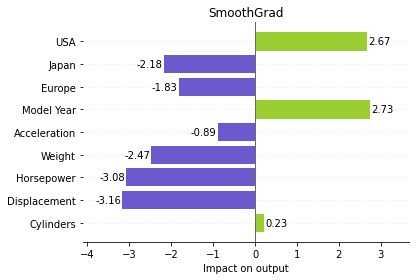

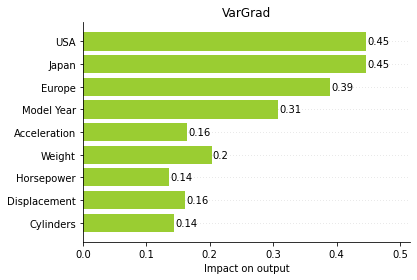

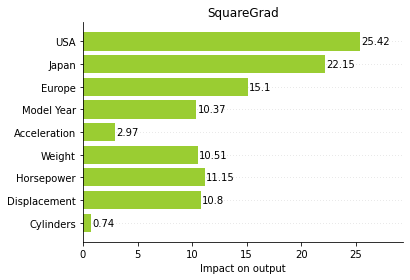

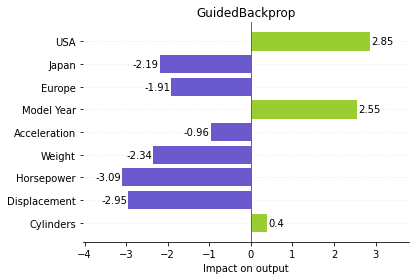

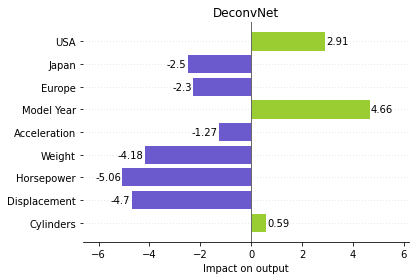

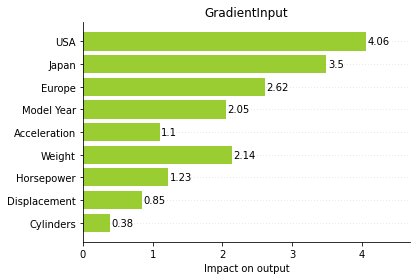

In [ ]:
for exp_index, (exp_method, exp) in enumerate(explanations):
    plot_mean_feature_impact(exp, features_name)
    plt.title(exp_method)
    plt.show()

### A much more informative overall plot

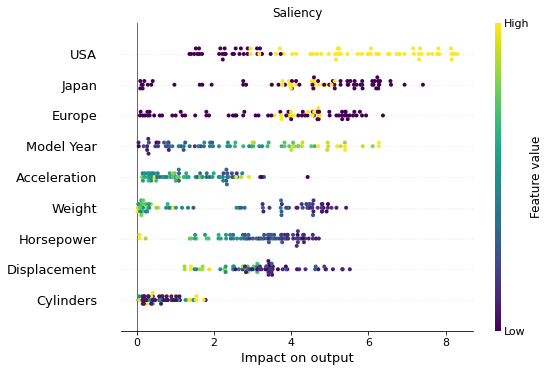

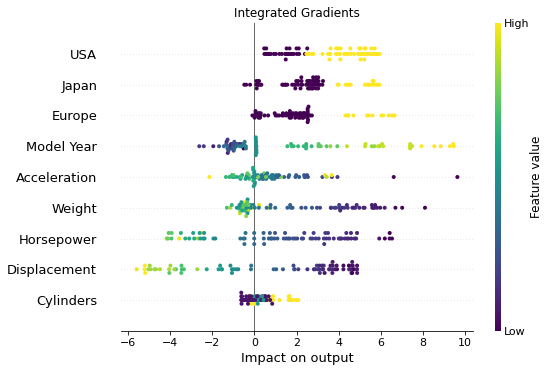

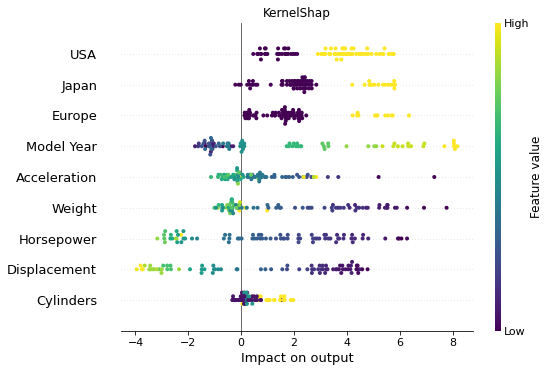

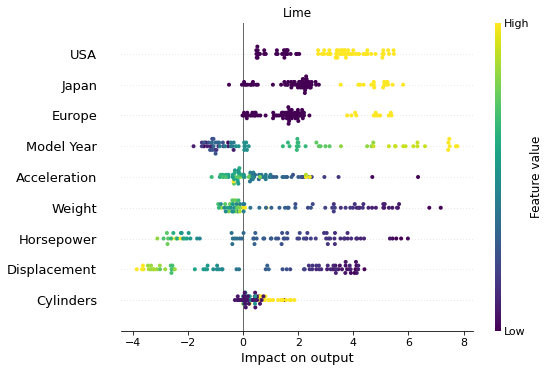

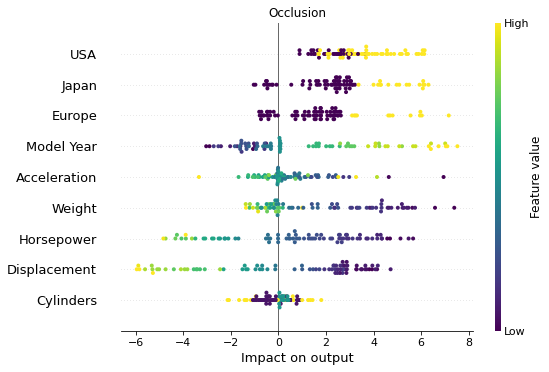

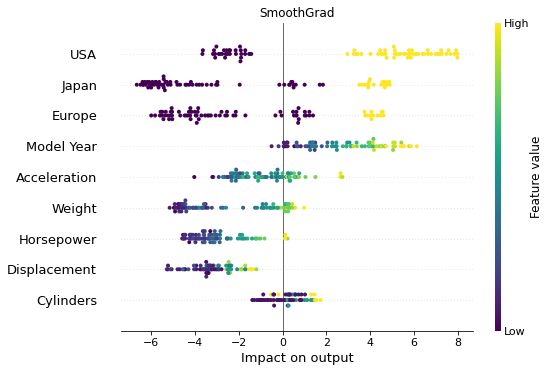

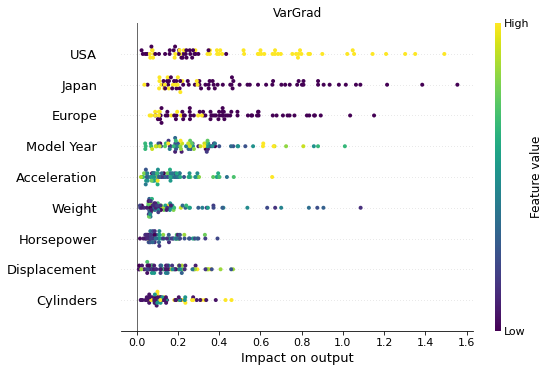

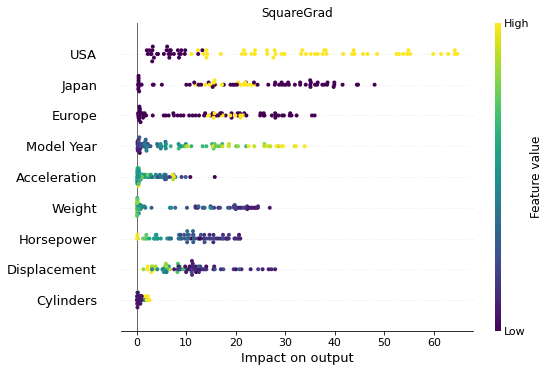

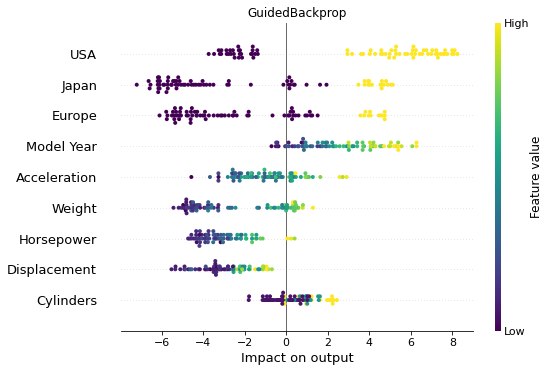

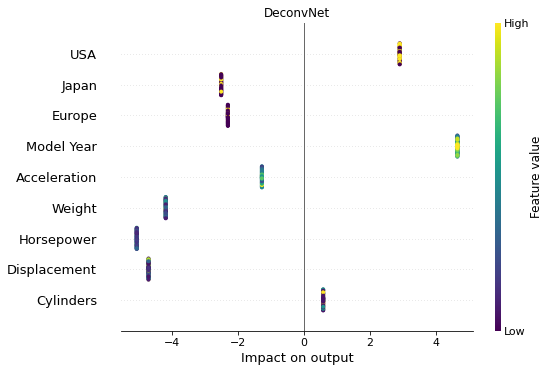

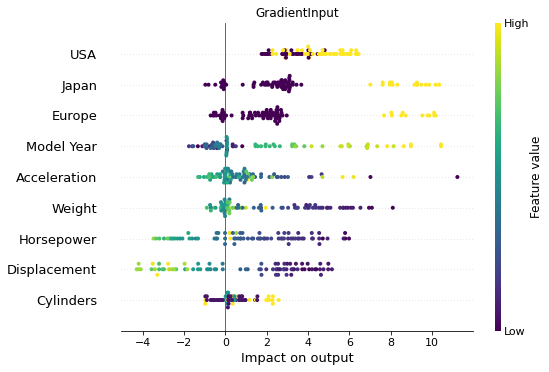

In [ ]:
for exp_index, (exp_method, exp) in enumerate(explanations):
    summary_plot_tabular(
        exp,
        features_values=test_features,
        features_name=features_name,
    )
    plt.title(exp_method)
    plt.show()

At first sight, it seems that the origin of the car got a significant impact towards the prediction. In order to confirm our intuition we will focus on the 4 features which have a mean absolute impact greater than the others.

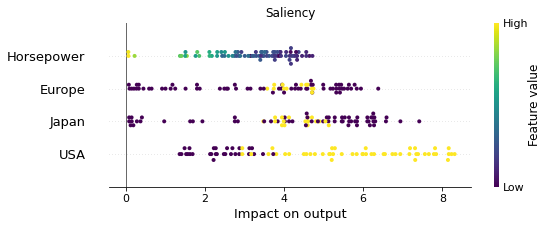

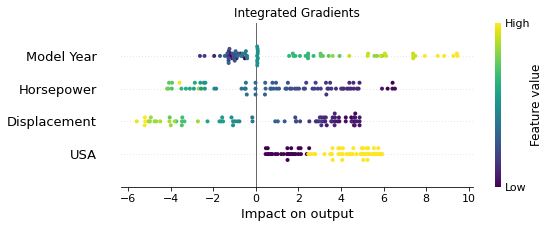

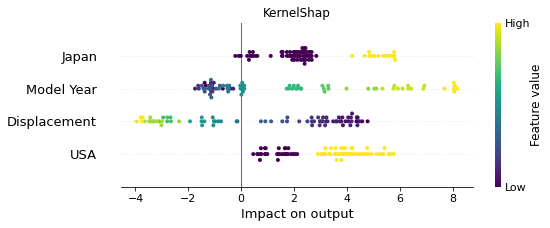

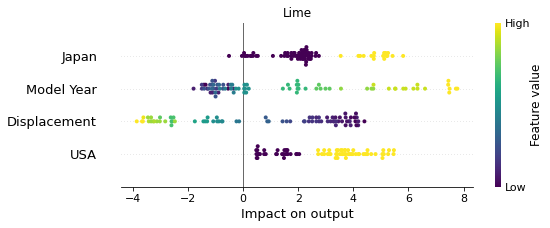

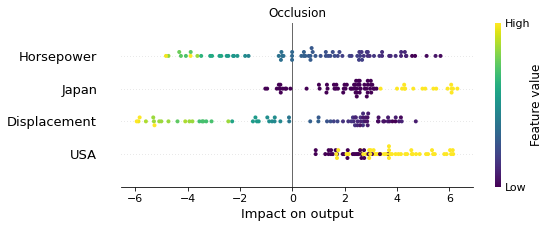

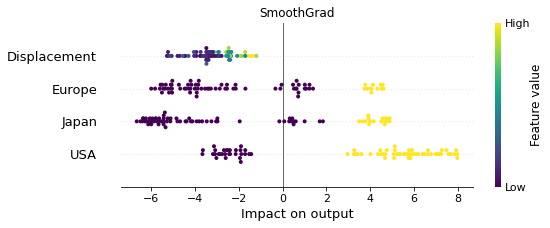

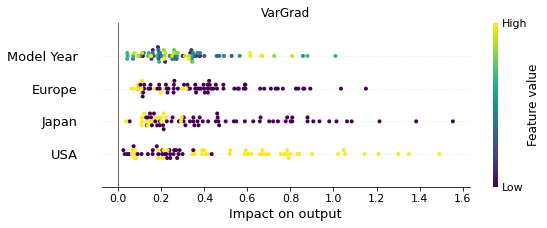

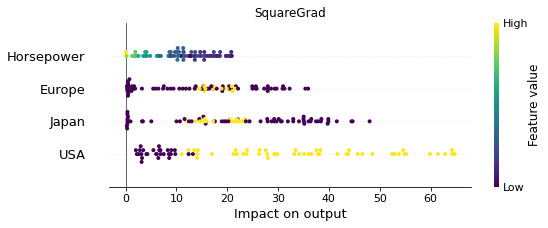

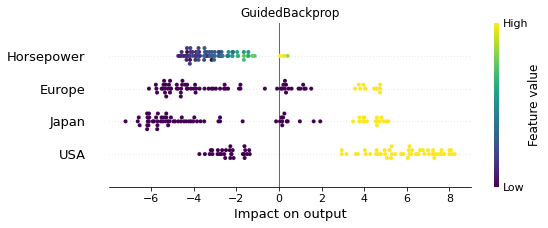

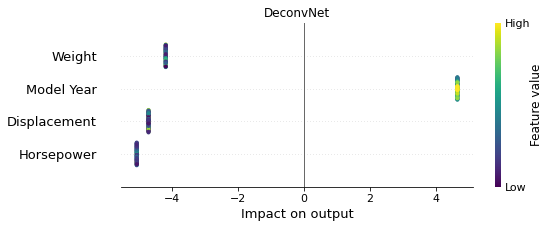

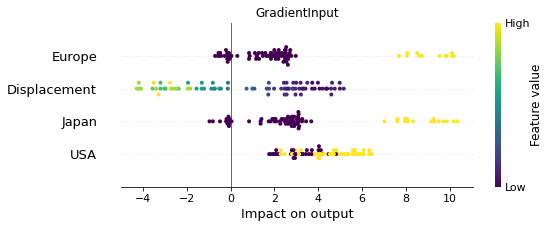

In [ ]:
for exp_index, (exp_method, exp) in enumerate(explanations):
    summary_plot_tabular(
        exp,
        features_values = test_features,
        features_name=features_name,
        max_display=4
    )
    plt.title(exp_method)
    plt.show()

## Leverage Attributions

As expected the origin of the car appears most of the time as a significant feature which can let us believe there is some kind of bias when training our model. Let's investigate that in our data.

In [ ]:
dataset_analysis = raw_dataset.copy()
# the dataset contains na value, we just drop them
dataset_analysis = dataset_analysis.dropna()

dataset_analysis['Origin'] = dataset_analysis['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
analysis = dataset_analysis.groupby('Origin')

In [ ]:
analysis.mean()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
Origin,,,,,,,
Europe,27.602941,4.161765,109.632353,80.558824,2433.470588,16.794118,75.676471
Japan,30.450633,4.101266,102.708861,79.835443,2221.227848,16.172152,77.443038
USA,20.033469,6.277551,247.512245,119.048980,3372.489796,14.990204,75.591837


In [ ]:
analysis.std()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
Origin,,,,,,,
Europe,6.580182,0.506975,22.693220,20.157871,491.813867,3.087813,3.422669
Japan,6.090048,0.590414,23.140126,17.819199,320.497248,1.954937,3.650595
USA,6.440384,1.655996,98.376347,39.897790,795.346690,2.736020,3.660368


The origin of the car seems to be a strong baseline towards the prediction and it makes sense especially if the car is coming from the USA.
For instance, considering our explanations and the previous quick analysis we can expect our values to be all shifted if we swap the origin of a car between USA and Europe.
First we will check the performance of the model on cars coming from the USA and then we will pertubed the labels by declaring those cars coming from Europe.

In [ ]:
us_val = test_features[:,8]
test_indx_usa = np.where(np.abs(us_val-0.776)<1e-3)

In [ ]:
us_predict = dnn_model.predict(test_features[test_indx_usa]).flatten()

In [ ]:
test_labels_us = test_labels.to_numpy()

array([15. , 10. ,  9. , 19. , 14. , 14. , 13. , 18. , 25. , 13. , 28. ,
       13. , 14. , 15. , 13. , 18. , 12. , 16. , 26. , 16. , 18. , 20. ,
       18. , 19. , 26. , 17.5, 22.5, 29. , 20. , 13. , 36.1, 20.5, 20.8,
       18.1, 30.9, 16.5, 15.5, 18.5, 19.1, 27.9, 26.6, 23.5, 30. , 34.4,
       22.4, 26.6, 28. , 34. , 28. ])

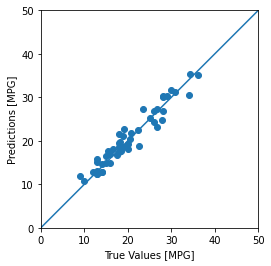

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels_us[test_indx_usa], us_predict)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

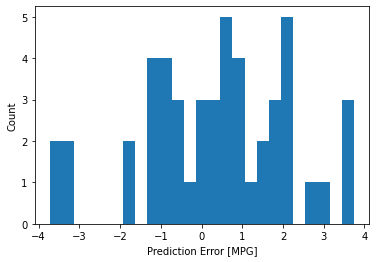

In [ ]:
error = us_predict - test_labels_us[test_indx_usa]
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

We will now pertub our model by declaring that cars from the US are from Europe

In [ ]:
pertub_features = test_features[test_indx_usa]
temp = np.copy(pertub_features)
pertub_features[:,8] = pertub_features[:,6]
pertub_features[:,6] = temp[:,8]

In [ ]:
pertub_predict = dnn_model.predict(pertub_features)

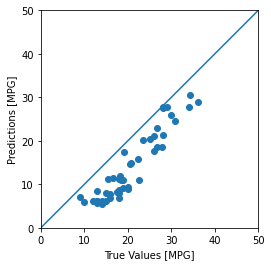

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels_us[test_indx_usa], pertub_predict)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

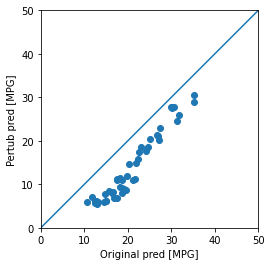

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(us_predict, pertub_predict)
plt.xlabel('Original pred [MPG]')
plt.ylabel('Pertub pred [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
mean_difference = np.mean(np.abs(pertub_predict - us_predict))
std_diff = np.std(np.abs(pertub_predict - us_predict))
print("Mean difference between original and pertubed: %s +- %s"%(mean_difference,std_diff))

Mean difference between original and pertubed: 10.249264 +- 6.7146907


As the explanations highlighted, the origin of the car is significant towards the precision of our prediction!